## Import dependencies

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
% matplotlib inline

# geo libraries
import shapely
from shapely.geometry import Point, Polygon
import shapely.wkt
import geopandas as gpd
import contextily as ctx

# colors
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors

In this part, we present visualizations for the main part of our research, i.e. grids data. In the first step, we perform a data transformation. In the second step, we present maps showing interesting relationships for each of the analyzed cities. We focus primarily on confronting Inpost points with their competition, as well as on showing interesting variables, both demographic and determining points of interest.

Taking into account the transformations, we obtain the following variables for visualization:
- **leader** - for each grid we check which operator has the most points. In the case of an equal number of points, we choose leader according to the highest total number of points. If no operator has a point in a given grid, then there is no leader.
- **dominance_inpost2** - if Inpost has more own points than 50% of the sum of all other operators - the value is True, otherwise the value is False.

Additionally, we create own colour pallets with *make_colormap* function.

We present visualizations according to variables, i.e. each visualized feature for 2 cities.

## Loading datasets

In [18]:
df_warszawa =pd.read_csv("../datasets/preprocessed_data/df_warszawa.csv")
df_krakow = pd.read_csv("../datasets/preprocessed_data/df_krakow.csv")
df_warszawa['city'] = 'Warszawa'
df_krakow['city'] = 'Krakow'

In [19]:
df_all = pd.concat([df_warszawa, df_krakow])

## Transformations of datasets for visualisations

In [20]:
def transform_df(df):
    
    # geo changes
    df['geometry'] = df.apply(lambda x: shapely.wkt.loads(x['geometry']), axis=1)
    df = gpd.GeoDataFrame(df, geometry = 'geometry', crs = "epsg:4258")
    
    # new variables
    df['operators'] = df.apply(lambda x: [x['inpost'], x['poczta'], x['dhl'], x['dpd'], x['ruch'], x['ups'], x['fedex']], axis = 1)
    df['leader'] = df.apply(lambda x: np.max(x['operators']) != 0, axis = 1)
    df['pos'] = df.apply(lambda x: np.where((x['leader'] == 1), np.argmax(x['operators']), 100), axis = 1)
    
    # dictionaries for applying
    dict_pos = {0: 'inpost', 1: 'poczta', 2: 'dhl', 3: 'other', 4: 'other', 5: 'other', 6: 'other', 100: 'no_leader'}
    dict_pos2 = {0: 'inpost', 1: 'poczta', 2: 'dhl', 3: 'dpd', 4: 'ruch', 5: 'ups', 6: 'fedex', 100: 'no_leader'}
    
    # new variables
    df['leader'] = df['pos'].replace(dict_pos)
    df['no_leader'] = 0
    df['leader_number'] = df.apply(lambda x: x[dict_pos2[float(x['pos'])]], axis = 1)
    df['other'] = df['dhl'] + df['dpd'] + df['fedex'] + df['poczta'] + df['ruch'] + df['ups']
    df['dominance_inpost'] = df['inpost'] > df['other']
    df['dominance_inpost2'] = df['inpost'] > 1/2*df['other']
    
    # changing crs (essential change for library contextily to show visualisation on map)
    df = df.to_crs(epsg=3857)
    
    return df

In [21]:
df_warszawa = transform_df(df_warszawa)
df_krakow = transform_df(df_krakow)
df_all = transform_df(df_all)

## Own color pallettes

In [22]:
# function from stackoverflow for making own cmap
def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

c = mcolors.ColorConverter().to_rgb

In [23]:
# our own palletes with colours
operators_cmap = make_colormap([c('red'), 0.2, c('magenta'), 0.4, c('grey'), 0.6, c('green'), 0.8, c('blue')])
blues = make_colormap([c('grey'), c('skyblue'), 0.1, c('skyblue'), c('aqua'), 0.2, c('aqua'), c('blue')])
greens = make_colormap([c('grey'), c('lightgreen'), 0.1, c('lightgreen'), c('lime'), 0.4, c('lime'), c('green')])
greys_cmap = make_colormap([c('grey'), c('grey'), 0.33, c('grey'), c('grey'), 0.66, c('grey')])
reds_cmap = make_colormap([c('lightcoral'), c('salmon'), 0.2, c('salmon'), c('indianred'), 0.4, c('indianred'), c('firebrick')])
blues_cmap = make_colormap([c('lightblue'), c('aqua'), 0.2, c('aqua'), c('deepskyblue'), 0.4, c('deepskyblue'), c('blue')])
greens_cmap = make_colormap([c('lightgreen'), c('lime'), 0.2, c('lime'), c('limegreen'), 0.4, c('limegreen'), c('green')])
pinks_cmap = make_colormap([c('violet'), c('magenta'), 0.2, c('magenta'), c('darkviolet'), 0.4, c('darkviolet'), c('purple')])
binary_cmap = make_colormap([c('red'), c('red'), 0.5, c('green'), c('green')])

## Function for visualisation

In [24]:
def visualisation_basic(df):
    
    fig, ax = plt.subplots(1, 2, figsize = (20, 10))
    print('\nBasic plot of city')
    ctx.add_basemap(df[df.city == 'Warszawa'].plot(figsize=(20,10), alpha = 0.4, edgecolor='black', linewidth=3, legend = True, ax = ax[0]))
    ax[0].set_axis_off()
    ax[0].set_title('Basic plot of Warszawa')
    ctx.add_basemap(df[df.city == 'Krakow'].plot(figsize=(20,10), alpha = 0.4, edgecolor='black', linewidth=3, legend = True, ax = ax[1]))
    ax[1].set_axis_off()
    ax[1].set_title('Basic plot of Kraków')
    plt.plot()
    plt.show()
    
def visualisation_leader(df):    
    fig, ax = plt.subplots(1, 2, figsize = (20, 10))
    print('\nLeader of operators')
    ctx.add_basemap(df[df.city == 'Warszawa'].plot(figsize=(20,10), column="leader", categorical = True, legend=True, cmap=operators_cmap, edgecolor='black', alpha = 0.7, ax = ax[0]))
    ax[0].set_axis_off()
    ax[0].set_title('Leader of operators in Warszawa')
    ctx.add_basemap(df[df.city == 'Krakow'].plot(figsize=(20,10), column="leader", categorical = True, legend=True, cmap=operators_cmap, edgecolor='black', alpha = 0.7, ax = ax[1]))
    ax[1].set_axis_off()
    ax[1].set_title('Leader of operators in Kraków')
    plt.plot()
    plt.show()

def visualisation_dominance(df):    
    fig, ax = plt.subplots(1, 2, figsize = (20, 10))
    print('\nDominance of inpost points over all other operators - > 50%')
    ctx.add_basemap(df[df.city == 'Warszawa'].plot(figsize=(20,10), column="dominance_inpost2", categorical = True, legend=True, cmap=binary_cmap, edgecolor='white', alpha = 0.7, ax = ax[0]))
    ax[0].set_axis_off()
    ax[0].set_title('Dominance of Inpost points in Warszawa')
    ctx.add_basemap(df[df.city == 'Krakow'].plot(figsize=(20,10), column="dominance_inpost2", categorical = True, legend=True, cmap=binary_cmap, edgecolor='white', alpha = 0.7, ax = ax[1]))
    ax[1].set_axis_off()
    ax[1].set_title('Dominance of Inpost points in Kraków')
    plt.plot()
    plt.show()

def visualisation_total(df):
    fig, ax = plt.subplots(1, 2, figsize = (20, 10))
    print('\nTotal')
    ctx.add_basemap(df[df.city == 'Warszawa'].plot(figsize=(20,10), column="tot", legend=True, cmap='Reds', edgecolor='white', alpha = 0.7, ax = ax[0]))
    ax[0].set_axis_off()
    ax[0].set_title('Total population in Warszawa')
    ctx.add_basemap(df[df.city == 'Krakow'].plot(figsize=(20,10), column="tot", legend=True, cmap='Reds', edgecolor='white', alpha = 0.7, ax = ax[1]))
    ax[1].set_axis_off()
    ax[1].set_title('Total population in Kraków')
    plt.plot()
    plt.show()

def visualisation_forests(df):    
    fig, ax = plt.subplots(1, 2, figsize = (20, 10))
    print('\nForests')
    ctx.add_basemap(df[df.city == 'Warszawa'].plot(figsize=(20,10), column="forests", legend=True, cmap=greens, edgecolor='white', alpha = 0.7, ax = ax[0]))
    ax[0].set_axis_off()
    ax[0].set_title('Number of forests in Warszawa')
    ctx.add_basemap(df[df.city == 'Krakow'].plot(figsize=(20,10), column="forests", legend=True, cmap=greens, edgecolor='white', alpha = 0.7, ax = ax[1]))
    ax[1].set_axis_off()
    ax[1].set_title('Number of forests in Kraków') 
    plt.plot()
    plt.show()

def visualisation_schools(df):        
    fig, ax = plt.subplots(1, 2, figsize = (20, 10))
    print('\nSchools')
    ctx.add_basemap(df[df.city == 'Warszawa'].plot(figsize=(20,10), column="schools", legend=True, cmap=blues, edgecolor='white', alpha = 0.7, ax = ax[0]))
    ax[0].set_axis_off()
    ax[0].set_title('Number of schools in Warszawa')
    ctx.add_basemap(df[df.city == 'Krakow'].plot(figsize=(20,10), column="schools", legend=True, cmap=blues, edgecolor='white', alpha = 0.7, ax = ax[1]))
    ax[1].set_axis_off()
    ax[1].set_title('Number of schools in Kraków')
    plt.plot()
    plt.show()
    

The figure below shows all cities with the background of OSM maps.


Basic plot of city


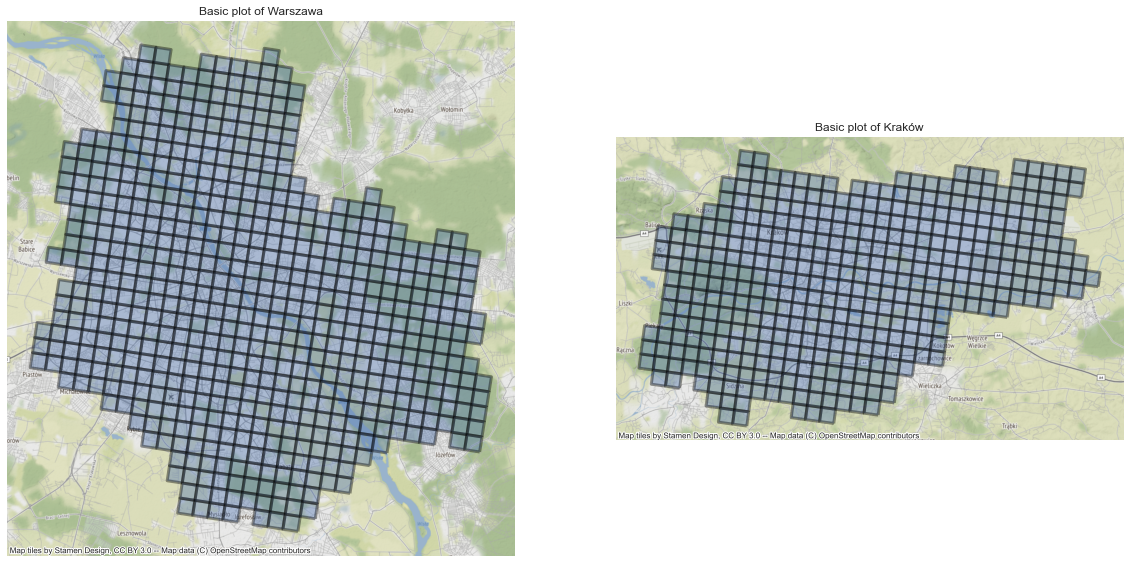

In [25]:
visualisation_basic(df_all)

The next figure shows the leader of the operators in each grid. We can see that Poczta Polska dominates the city center (blue color on the map). In turn, Inpost dominates around the center (pink color), i.e. around Poczta Polska points. DHL (red color) and other smaller operators (green color) are the leaders in a few points. On the outskirts of cities, as a rule, there is no leader (gray color).


Leader of operators


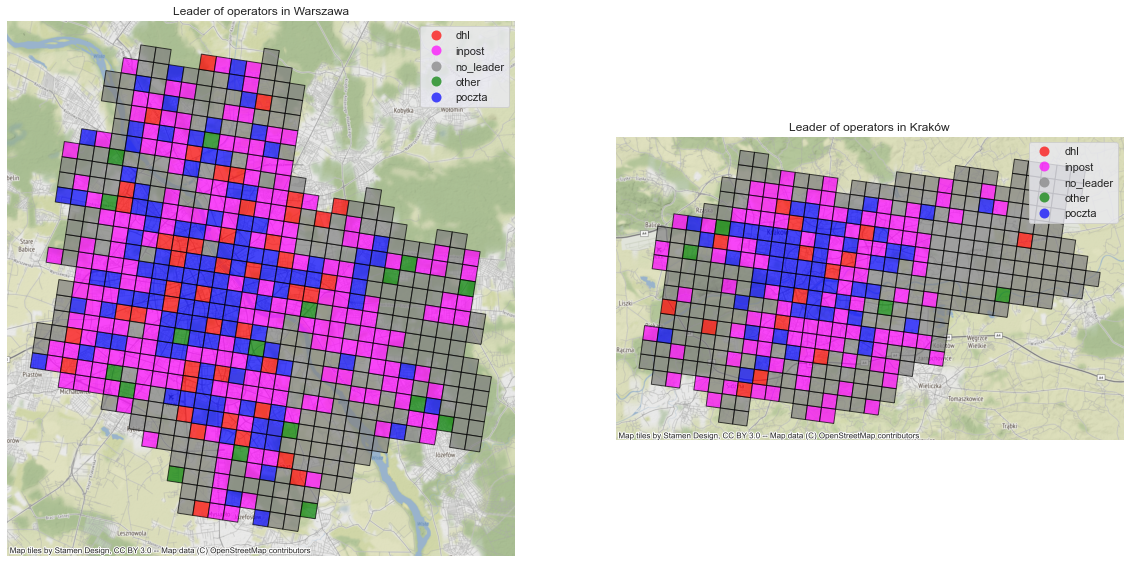

In [26]:
visualisation_leader(df_all)

The figure below shows where Inpost dominates over other operators. Green color means that Inpost points account for more than 50% of all other operators. Referring to the previous figure, Inpost's dominance is mainly in those points where Inpost is the leader on its own.


Dominance of inpost points over all other operators - > 50%


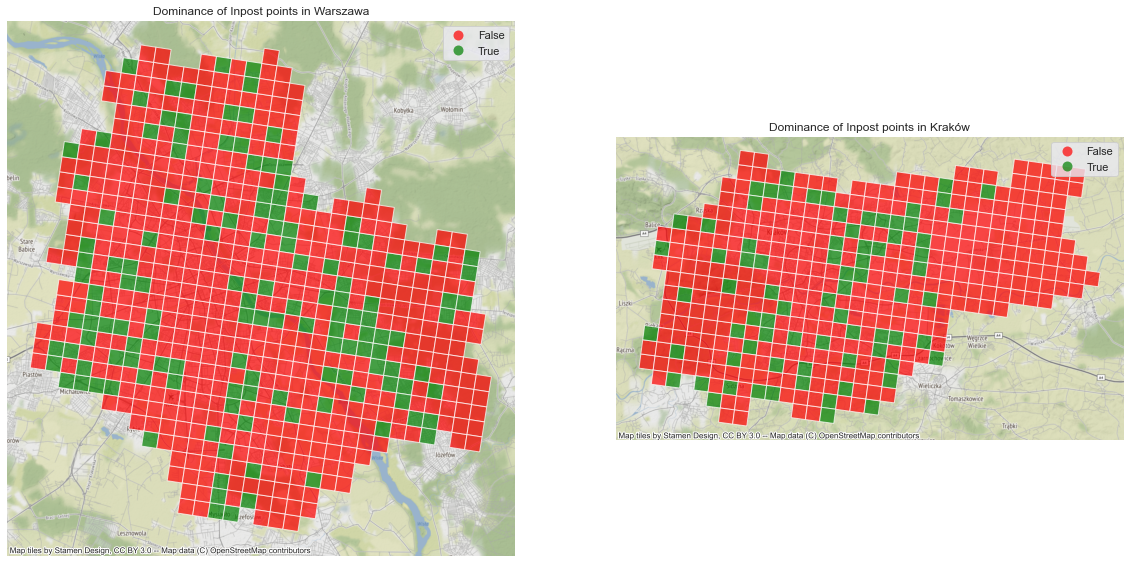

In [27]:
visualisation_dominance(df_all)

Then we show how the demographic variable is distributed in cities. As expected, total population is the highest in city centers.


Total


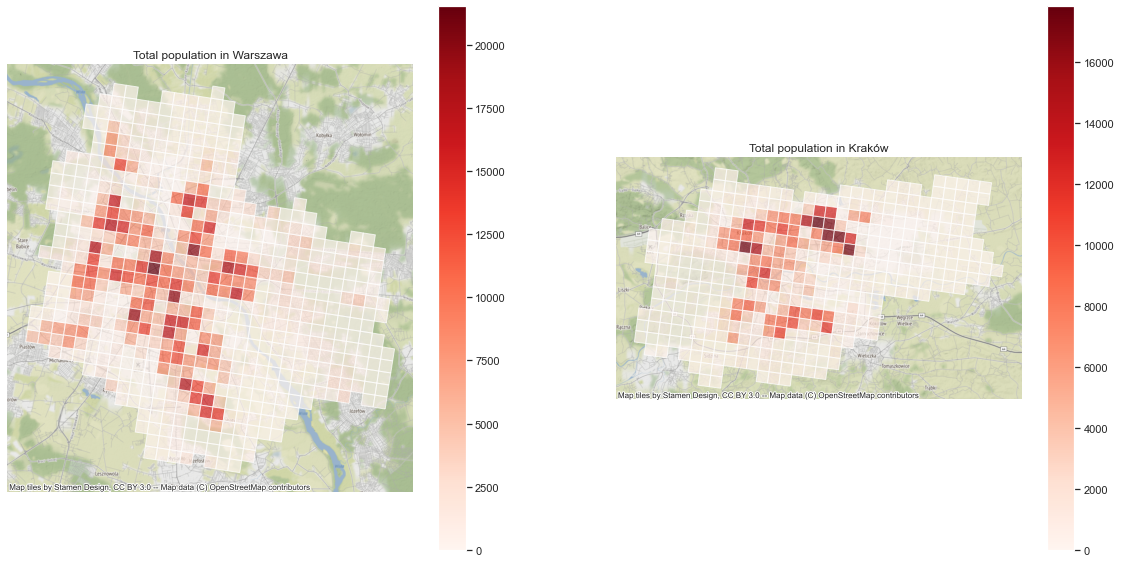

In [28]:
visualisation_total(df_all)

Taking into account forests points, their distribution on the map is very regual. It is noticeable that there is also a lot of green areas on the outskirts of cities.


Forests


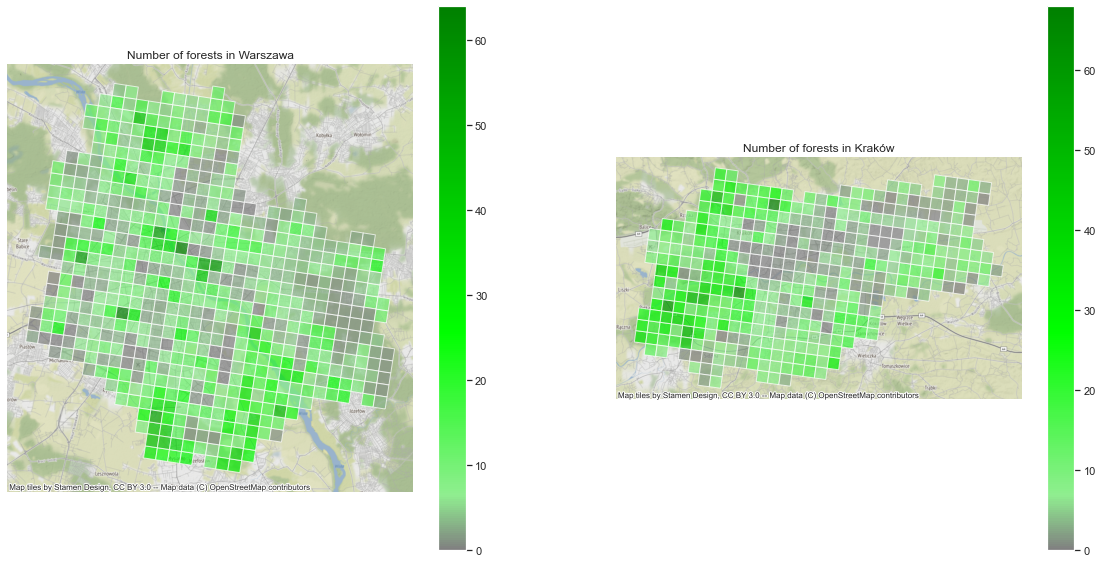

In [29]:
visualisation_forests(df_all)

Finally, we show the location of the schools (elementary schools, kindergartens, etc.). As expected, the highest number of schools is in the center, where also the total population is highest.


Schools


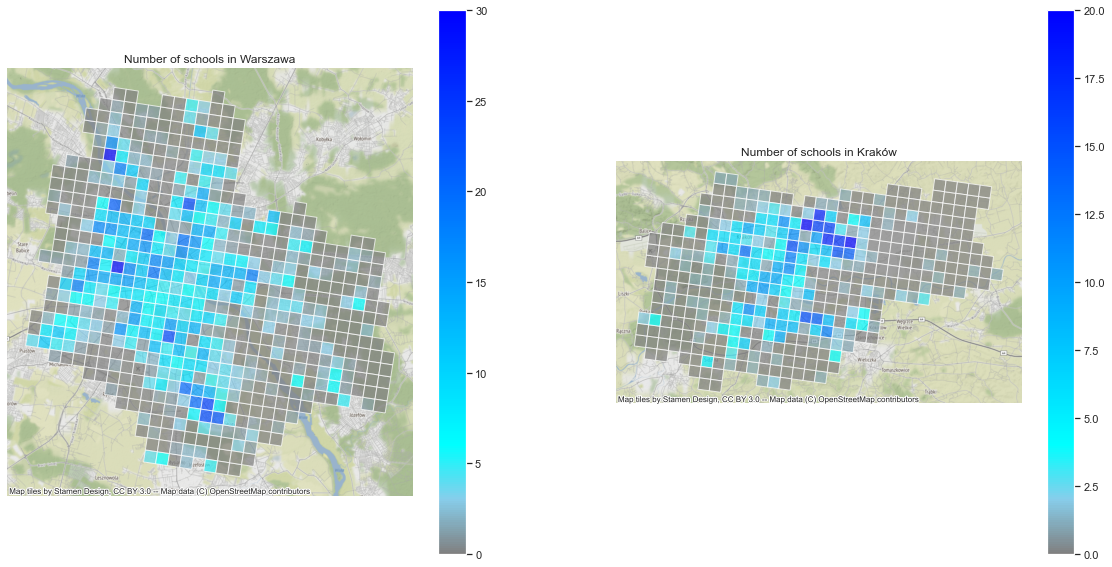

In [30]:
visualisation_schools(df_all)